In [7]:
from functools import partial

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrng 

from jax import Array

import matplotlib.pyplot as plt


jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=3)

In [8]:
seed = 0
n = 4 # Number of states
m = 3 # Number of observations

key = jrng.key(seed)
key, O_key, mu_key = jrng.split(key, 3)

# Construct a transition matrix that stays in the same state with 99% probability and transitions to the next with 1%
T = 0.999 * jnp.eye(n, dtype=jnp.float64)
T = T + 0.001 * jnp.eye(n, k=1)
T = T / jnp.sum(T, axis=-1)[:,None]

# Construct an initial state distribution where the earlier states are more likely
mu = jnp.exp(- 5 * jnp.arange(0, n, dtype=jnp.float64))
mu = mu.at[n -1].set(0)
mu = mu / jnp.sum(mu)

# Construct a noisy observation matrix
O = jrng.uniform(O_key, (n, m), dtype=jnp.float64)
O = O * jnp.linspace(0, 1, n)[:, None]
for s in range(n):
    O = O.at[s, (s * m) // n ].set(.5)
O = O.at[n-1].set(0.0)
O = O.at[n-1, m-1].set(1.0)
O = O / jnp.sum(O, axis=-1)[:,None]

print("T row sums:", jnp.sum(T, axis=-1), 
      "\nO row sums:", jnp.sum(O, axis=-1), 
      "\nmu sum:", jnp.sum(mu)[None])

T row sums: [1. 1. 1. 1.] 
O row sums: [1. 1. 1. 1.] 
mu sum: [1.]


# Likelihood computation of a sequence

We now look at the likelihood of a sequence of observations $o_1, \dots, o_T$ given a set of parameters $T, O, \mu$

In [9]:
@partial(jax.jit, static_argnames="length")
def generate_sequence(
        key: Array,
        transition_matrix: Array, 
        observation_matrix: Array, 
        initial_distribution: Array, 
        length: int) -> Array:

    n, _ = observation_matrix.shape

    initial_key, sampling_key = jrng.split(key)
    initial_state = jrng.choice(initial_key, n, p=initial_distribution)

    p_samples = jrng.uniform(sampling_key, (length, 2))

    obs_cdf = jnp.cumsum(observation_matrix, axis=-1)
    trans_cdf = jnp.cumsum(transition_matrix, axis=-1)

    def step(state, p_samples):
        p_obs, p_state = p_samples

        observation = jnp.argmax(obs_cdf[state] >= p_obs)
        next_state = jnp.argmax(trans_cdf[state] >= p_state)

        return next_state, (state, observation)
    
    _, (states, observations) = lax.scan(step, initial_state, p_samples)

    return states, observations

@partial(jax.jit, static_argnames="length")
def generate_sequence_choice(
        key: Array,
        transition_matrix: Array, 
        observation_matrix: Array, 
        initial_distribution: Array, 
        length: int) -> Array:

    n, m = observation_matrix.shape

    initial_key, *key_array = jrng.split(key, 1 + length)
    initial_state = jrng.choice(initial_key, n, p=initial_distribution)


    def step(state, sampling_key):
        obs_key, state_key = jrng.split(sampling_key)

        observation = jrng.choice(obs_key, m, p=observation_matrix[state])
        next_state = jrng.choice(state_key, n, p=transition_matrix[state])

        return next_state, (state, observation)
    
    _, (states, observations) = lax.scan(step, initial_state, jnp.array(key_array))

    return states, observations



In [10]:
# generate_sequence(jrng.key(0), T, O, mu, 100)
# generate_sequence_choice(jrng.key(0), T, O, mu, 100)

# %timeit generate_sequence(jrng.key(0), T, O, mu, 100)
# %timeit generate_sequence_choice(jrng.key(0), T, O, mu, 100)


In [24]:
n_sequences = 200_000
len_sequence = 200

key = jrng.key(seed)
key, *sequence_keys = jrng.split(key, 1 + n_sequences)

states, observations = jax.vmap(lambda _key: generate_sequence(_key, T, O, mu, len_sequence))(jnp.array(sequence_keys))

In [25]:
from likelihoods import likelihood

# test_sequence = observations[5, ...]
test_sequence = jnp.zeros_like(observations[0, ...])

state_likelihoods, llhood_vec = likelihood(test_sequence, T, O, mu, return_stats=True)

In [26]:
from likelihoods import log_likelihood

state_log_likelihoods, log_llhood_vec = log_likelihood(test_sequence, T, O, mu, return_stats=True)

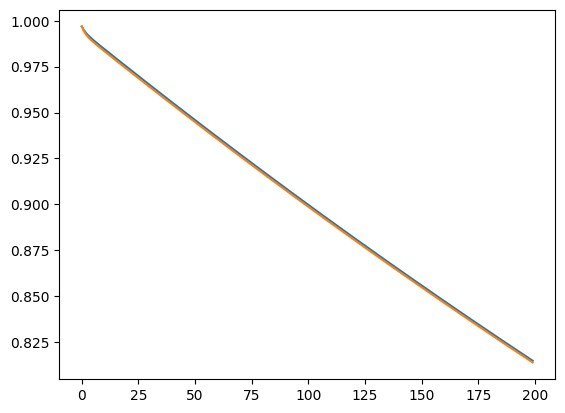

In [27]:
plt.plot(llhood_vec)
plt.plot(jnp.exp(log_llhood_vec))
plt.show()

In [28]:
state_likelihoods, llhood_vec = likelihood(test_sequence, T, O, mu, return_stats=True)

identical_indices = jnp.all(observations == test_sequence, axis=-1)
identical_samples = jnp.sum(identical_indices)

sampled_likelihood = identical_samples / observations.shape[0]

print("Computation was performed as:", log_llhood_vec.dtype)

print(
    "Likelihood sampled:", sampled_likelihood, 
    "\nLikelihood computed:", llhood_vec[-1],
    "\nLog-Likelihood converted:", jnp.exp(log_llhood_vec[-1]))

Computation was performed as: float64
Likelihood sampled: 0.81393 
Likelihood computed: 0.8148897590330118 
Log-Likelihood converted: 0.8139533588291696


In [16]:
observations


Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 2, 2, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [17]:
identical_indices

Array([ True,  True,  True, ...,  True, False,  True], dtype=bool)

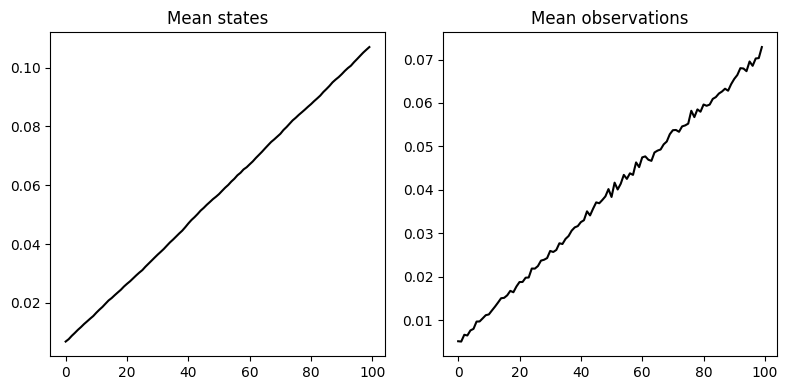

In [18]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,4)
n_samples = len(states)
ax[0].plot(jnp.mean(states, axis=0), "k")
ax[1].plot(jnp.mean(observations, axis=0), "k")
ax[0].set_title("Mean states")
ax[1].set_title("Mean observations")
plt.tight_layout()
plt.show()

In [19]:
state_distribution = lax.map(lambda s: jnp.count_nonzero(states == s, axis=0), jnp.arange(n)) / states.shape[0]
state_distribution

Array([[9.931e-01, 9.923e-01, 9.912e-01, 9.902e-01, 9.891e-01, 9.882e-01,
        9.872e-01, 9.863e-01, 9.854e-01, 9.845e-01, 9.834e-01, 9.824e-01,
        9.815e-01, 9.804e-01, 9.793e-01, 9.785e-01, 9.776e-01, 9.767e-01,
        9.758e-01, 9.748e-01, 9.738e-01, 9.730e-01, 9.720e-01, 9.710e-01,
        9.702e-01, 9.694e-01, 9.683e-01, 9.673e-01, 9.662e-01, 9.652e-01,
        9.642e-01, 9.633e-01, 9.624e-01, 9.613e-01, 9.602e-01, 9.593e-01,
        9.583e-01, 9.573e-01, 9.564e-01, 9.553e-01, 9.540e-01, 9.529e-01,
        9.520e-01, 9.510e-01, 9.499e-01, 9.490e-01, 9.481e-01, 9.472e-01,
        9.463e-01, 9.456e-01, 9.447e-01, 9.437e-01, 9.427e-01, 9.418e-01,
        9.408e-01, 9.398e-01, 9.387e-01, 9.379e-01, 9.369e-01, 9.362e-01,
        9.352e-01, 9.343e-01, 9.332e-01, 9.323e-01, 9.313e-01, 9.303e-01,
        9.293e-01, 9.283e-01, 9.275e-01, 9.266e-01, 9.257e-01, 9.245e-01,
        9.236e-01, 9.225e-01, 9.215e-01, 9.207e-01, 9.197e-01, 9.190e-01,
        9.181e-01, 9.172e-01, 9.164e-0

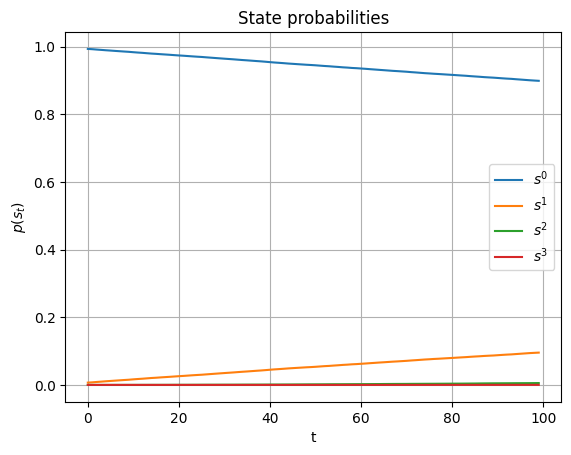

In [20]:
for k, state_prob in enumerate(state_distribution):
    plt.plot(state_prob, label=f"$s^{k}$")

plt.grid()
plt.legend()
plt.title("State probabilities")
plt.xlabel("t")
plt.ylabel("$p(s_t)$")
plt.show()

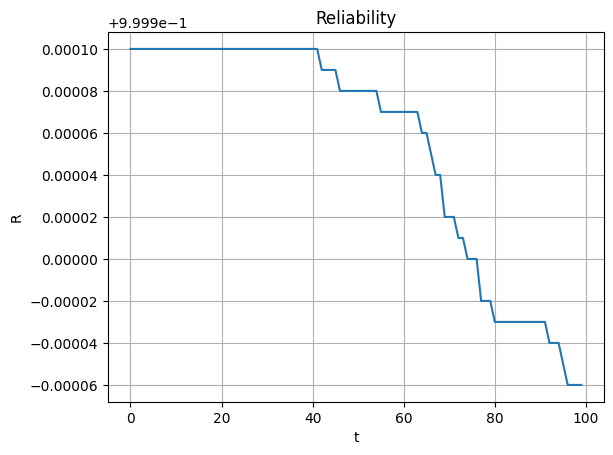

In [21]:
# Reliablility
p_failure = state_distribution[-1]
R = 1 - p_failure

plt.plot(R)
plt.grid()
plt.title("Reliability")
plt.xlabel("t")
plt.ylabel("R")
plt.show()
